In [1]:
%cd ../src/

/mnt/c/Users/Jacob/Desktop/prosjektoppgave/tcav_atari/src


In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, r2_score
from sklearn.model_selection import KFold

from concepts import concept_instances
from utils import load_data, prepare_folders, load_q_network_device

In [4]:
q_network, device = load_q_network_device()
data = load_data()
concept = concept_instances['ball right paddle (b)']
concept.prepare_data(data, max_size=1000)

In [5]:
class ProbeNetwork(nn.Module):
    def __init__(self, q_network, layer_index, input_dim, binary):
        super().__init__()
        self.binary = binary
        # Clone the original network up to layer
        self.features = nn.Sequential(*[layer for layer in q_network.network.children()][:layer_index])
        
        # Freeze the parameters of the original network
        for param in self.features.parameters():
            param.requires_grad = False
        
        # Add the new layer
        if binary:
            self.probe = nn.Sequential(nn.Linear(input_dim, 1), nn.Sigmoid())
        else:
            self.probe = nn.Sequential(nn.Linear(input_dim, 1))

    def forward_features(self, x):
        x = x / 255.0
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return x

    def forward_probe(self, x):
        x = self.probe(x)
        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = self.forward_probe(x)
        return x

    def _get_accuracy(self, x, y):
        y_pred = self.forward(x)
        y_pred = (y_pred > 0.5).float()
        correct = (y_pred == y).float().sum()
        accuracy = correct / y.size(0)
        return accuracy

    def _get_r2(self, x, y):
        y_pred = self.forward(x)
        total_variance = torch.var(y, unbiased=False)
        residual_variance = F.mse_loss(y_pred, y, reduction='sum')
        r2 = 1 - (residual_variance / (total_variance * y.size(0)))
        return r2
        
    def get_score(self, x, y):
        if self.binary:
            score = 2 * self._get_accuracy(x, y) - 1
        else:
            score = self._get_r2(x, y)
        return round(max(0.0, score.item()), 4)

In [6]:
obs_train = torch.tensor(concept.obs_train).float().to(device)
obs_test = torch.tensor(concept.obs_test).float().to(device)
train_values = torch.tensor(concept.values_train).float().to(device).unsqueeze(1)
test_values = torch.tensor(concept.values_test).float().to(device).unsqueeze(1)

In [7]:
layer_index = 8
input_dim = 512
binary = True
loss_fn = nn.MSELoss()
l1_lambda = 0.001
learning_rate = 0.001
epochs = 1000
probe_network = ProbeNetwork(q_network, layer_index, input_dim, binary).to(device)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, probe_network.parameters()), lr=learning_rate)

## Train the concept probe

In [8]:
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = probe_network(obs_train)
    train_loss = loss_fn(outputs, train_values)
    l1_reg = torch.tensor(0.0, device=device)
    for param in filter(lambda p: p.requires_grad, probe_network.parameters()):
        l1_reg += torch.norm(param, p=1)
    train_loss += l1_lambda * l1_reg
    train_loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        outputs = probe_network(obs_test)
        print(probe_network.get_score(obs_test, test_values))

0.0
0.6
0.64
0.66
0.67
0.69
0.72
0.72
0.7
0.7


torch.Size([1, 4, 84, 84])
Concept value: 0
Target concept value: 1


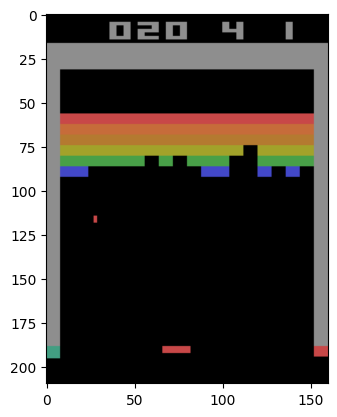

In [9]:
ex_idx = 1
example_obs = concept.obs_test[ex_idx]
example_obs = torch.from_numpy(example_obs).unsqueeze(0).to(device).float()
print(example_obs.shape)
print(f"Concept value: {concept.values_test[ex_idx]}")
target_concept_value = 1
print(f"Target concept value: {target_concept_value}")
plt.imshow(concept.images_test[ex_idx])
plt.show()

### concept backprop naive

In [10]:
pertubation_lr = 0.001
iterations = 1000
loss_ratio = 2000

# Initialize perturbation with small value
small_noise = torch.ones_like(example_obs) * 0.1
perturbation = small_noise.clone().detach().requires_grad_(True)
initial_prediction = probe_network(example_obs + perturbation)
print(f"Initial Prediction: {initial_prediction.item()}")

for i in range(iterations):
    # calculate how wrong the concept value is
    perturbed_obs = torch.nn.functional.relu(example_obs + perturbation)
    concept_value_pred = probe_network(perturbed_obs)
    loss1 = torch.norm(concept_value_pred - target_concept_value, p=1)
    loss2 = torch.norm(perturbation, p=2)
    total_loss = loss_ratio * loss1 + loss2
    if i % 50 == 0 or i == iterations - 1:
        print(f"Iteration {i:3d} - Loss1: {loss1:.4f}, Loss2: {loss2:.4f}, Total Loss: {total_loss:.4f}")
    total_loss.backward()

    # update perturbation
    with torch.no_grad():
        perturbation -= pertubation_lr * perturbation.grad
        perturbation.grad.zero_()
        
perturbed_obs = torch.nn.functional.relu(example_obs + perturbation)
final_prediction = probe_network(perturbed_obs)
print(f"Final Prediction: {final_prediction.item()}")

Initial Prediction: 0.19894985854625702
Iteration   0 - Loss1: 0.8011, Loss2: 16.8000, Total Loss: 1618.9003
Iteration  50 - Loss1: 0.7292, Loss2: 17.1596, Total Loss: 1475.5227
Iteration 100 - Loss1: 0.6492, Loss2: 18.0091, Total Loss: 1316.4481
Iteration 150 - Loss1: 0.5639, Loss2: 19.2698, Total Loss: 1147.0073
Iteration 200 - Loss1: 0.4904, Loss2: 20.6989, Total Loss: 1001.5139
Iteration 250 - Loss1: 0.4192, Loss2: 22.2509, Total Loss: 860.6869
Iteration 300 - Loss1: 0.3521, Loss2: 23.8914, Total Loss: 728.1500
Iteration 350 - Loss1: 0.2808, Loss2: 25.5872, Total Loss: 587.2223
Iteration 400 - Loss1: 0.2148, Loss2: 27.2024, Total Loss: 456.7567
Iteration 450 - Loss1: 0.1669, Loss2: 28.6057, Total Loss: 362.4649
Iteration 500 - Loss1: 0.1362, Loss2: 29.7612, Total Loss: 302.2010
Iteration 550 - Loss1: 0.1128, Loss2: 30.7811, Total Loss: 256.3131
Iteration 600 - Loss1: 0.0941, Loss2: 31.6896, Total Loss: 219.8743
Iteration 650 - Loss1: 0.0809, Loss2: 32.4665, Total Loss: 194.2691
Ite

In [11]:
def display_obs(tensor_obs, title):
    image = np.concatenate(tensor_obs.reshape(4, 84, 84).detach().cpu().numpy(), axis=1)
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

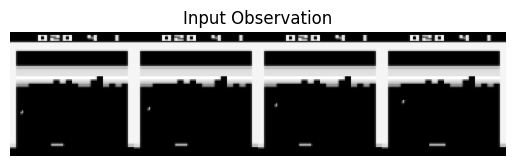

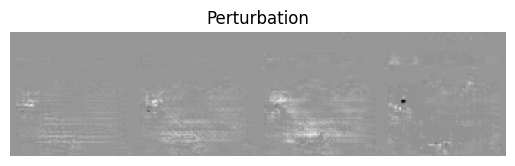

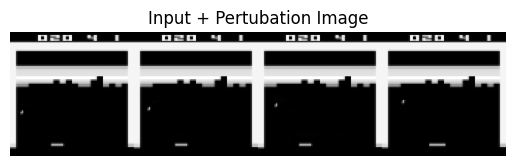

In [12]:
display_obs(example_obs, 'Input Observation')
display_obs(perturbation, 'Perturbation')
display_obs(perturbed_obs, 'Input + Pertubation Image')

### concept backprop distance on observation statistics

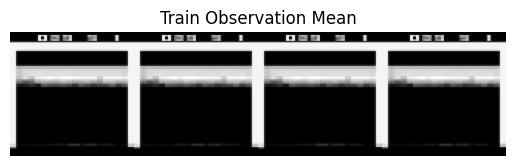

In [13]:
train_obs_means = concept.obs_train.mean(axis=0)
train_obs_means = torch.from_numpy(train_obs_means).unsqueeze(0).to(device).float()
display_obs(train_obs_means, 'Train Observation Mean')

In [14]:
pertubation_lr = 0.01
iterations = 1000
loss_ratio = 1000

# Initialize perturbation with small value
small_noise = torch.ones_like(example_obs) * 0.1
perturbation = small_noise.clone().detach().requires_grad_(True)
initial_prediction = probe_network(example_obs + perturbation)
print(f"Initial Prediction: {initial_prediction.item()}")

for i in range(iterations):
    perturbed_obs = torch.nn.functional.relu(example_obs + perturbation)
    concept_value_pred = probe_network(perturbed_obs)
    loss1 = torch.norm(concept_value_pred - target_concept_value, p=1)
    loss2 = torch.norm(perturbed_obs - train_obs_means, p=2)
    total_loss = loss_ratio * loss1 + loss2
    if i % 50 == 0:
        print(f"Epoch {i:3d} - Loss1: {loss1:.4f}, Loss2: {loss2:.4f}, Total Loss: {total_loss:.4f}")
    total_loss.backward()

    # update perturbation
    with torch.no_grad():
        perturbation -= pertubation_lr * perturbation.grad
        perturbation.grad.zero_()
        
perturbed_obs = torch.nn.functional.relu(example_obs + perturbation)
final_prediction = probe_network(perturbed_obs)
print(f"Final Prediction: {final_prediction.item()}")

Initial Prediction: 0.19894985854625702
Epoch   0 - Loss1: 0.8011, Loss2: 2200.3206, Total Loss: 3001.3706
Epoch  50 - Loss1: 0.4177, Loss2: 2199.6941, Total Loss: 2617.3748
Epoch 100 - Loss1: 0.1336, Loss2: 2199.0376, Total Loss: 2332.6208
Epoch 150 - Loss1: 0.0618, Loss2: 2198.4717, Total Loss: 2260.2959
Epoch 200 - Loss1: 0.0387, Loss2: 2197.9524, Total Loss: 2236.6206
Epoch 250 - Loss1: 0.0282, Loss2: 2197.4475, Total Loss: 2225.6970
Epoch 300 - Loss1: 0.0226, Loss2: 2196.9504, Total Loss: 2219.5132
Epoch 350 - Loss1: 0.0185, Loss2: 2196.4587, Total Loss: 2214.9380
Epoch 400 - Loss1: 0.0158, Loss2: 2195.9692, Total Loss: 2211.7319
Epoch 450 - Loss1: 0.0138, Loss2: 2195.4800, Total Loss: 2209.2363
Epoch 500 - Loss1: 0.0122, Loss2: 2194.9932, Total Loss: 2207.2036
Epoch 550 - Loss1: 0.0110, Loss2: 2194.5083, Total Loss: 2205.5378
Epoch 600 - Loss1: 0.0101, Loss2: 2194.0247, Total Loss: 2204.1216
Epoch 650 - Loss1: 0.0093, Loss2: 2193.5425, Total Loss: 2202.8655
Epoch 700 - Loss1: 0.0

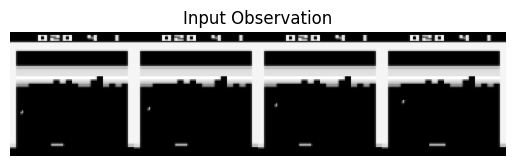

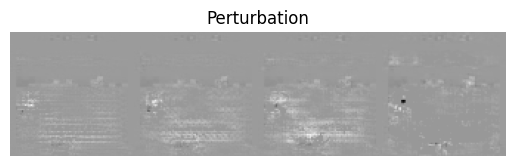

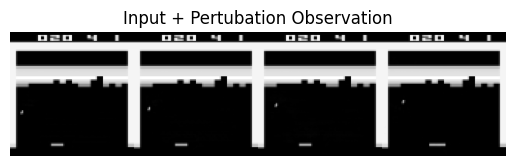

In [15]:
display_obs(example_obs, 'Input Observation')
display_obs(perturbation, 'Perturbation')
display_obs(perturbed_obs, 'Input + Pertubation Observation')

### DeepDream of highest Q-value

In [16]:
pertubation_lr = 0.01
iterations = 1000
loss_ratio = 1000

# Initialize perturbation with small value
small_noise = torch.ones_like(example_obs) * 0.1
perturbation = small_noise.clone().detach().requires_grad_(True)
initial_prediction = q_network(example_obs + perturbation)
print(f"Initial Prediction: {initial_prediction}")

for i in range(iterations):
    perturbed_obs = torch.nn.functional.relu(example_obs + perturbation)
    
    q_values = q_network(perturbed_obs)
    
    loss1 = -torch.min(q_values)
    loss2 = torch.norm(perturbation, p=2)
    total_loss = loss_ratio * loss1 + loss2
    
    if i % 50 == 0:
        print(f"Epoch {i:3d} - Loss1: {loss1:.4f}, Loss2: {loss2:.4f}, Total Loss: {total_loss:.4f}")
    
    total_loss.backward()
    with torch.no_grad():
        perturbation -= pertubation_lr * perturbation.grad
        perturbation.grad.zero_()

perturbed_obs = torch.nn.functional.relu(example_obs + perturbation)
final_prediction = q_network(perturbed_obs)
print(f"Final Prediction: {final_prediction}")

Initial Prediction: tensor([[4.8708, 4.8712, 4.8648, 4.8280]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
Epoch   0 - Loss1: -4.8280, Loss2: 16.8000, Total Loss: -4811.2349
Epoch  50 - Loss1: -4.9837, Loss2: 18.6378, Total Loss: -4965.0615
Epoch 100 - Loss1: -5.1011, Loss2: 23.0158, Total Loss: -5078.0483
Epoch 150 - Loss1: -5.2048, Loss2: 28.0517, Total Loss: -5176.7158
Epoch 200 - Loss1: -5.3465, Loss2: 34.2073, Total Loss: -5312.2964
Epoch 250 - Loss1: -5.4994, Loss2: 40.6927, Total Loss: -5458.7563
Epoch 300 - Loss1: -5.6261, Loss2: 46.6824, Total Loss: -5579.4292
Epoch 350 - Loss1: -5.7553, Loss2: 53.1497, Total Loss: -5702.1499
Epoch 400 - Loss1: -5.9224, Loss2: 60.6834, Total Loss: -5861.7251
Epoch 450 - Loss1: -6.2109, Loss2: 69.9610, Total Loss: -6140.9219
Epoch 500 - Loss1: -12.5856, Loss2: 99.1267, Total Loss: -12486.4736
Epoch 550 - Loss1: -22.0788, Loss2: 139.3108, Total Loss: -21939.4922
Epoch 600 - Loss1: -25.2807, Loss2: 165.3772, Total Loss: -25115.3438
Epoch 65

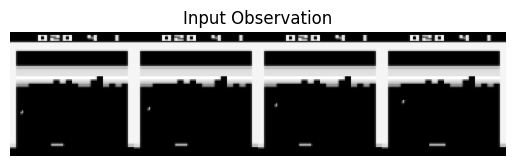

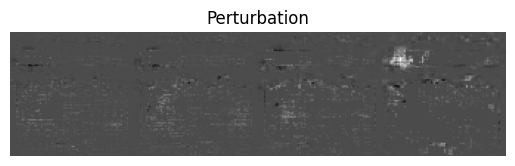

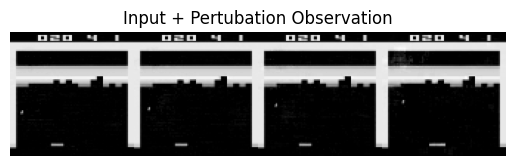

In [17]:
display_obs(example_obs, 'Input Observation')
display_obs(perturbation, 'Perturbation')
display_obs(perturbed_obs, 'Input + Pertubation Observation')

### Train autoencoder up until a layer

In [18]:
class Encoder(nn.Module):
    def __init__(self, latent_variables):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(4, 32, 8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 512),
            nn.ReLU(),
            nn.Linear(512, latent_variables)  # projects down to 64 latent variables
        )

    def forward(self, x):
        x = x / 255.0  # Normalizing input
        return self.encoder(x)

class Decoder(nn.Module):
    def __init__(self, latent_variables):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(latent_variables, 512),  # Projection back to flattened size
            nn.ReLU(),
            nn.Linear(512, 64 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),  # Unflattening the tensor
            nn.ConvTranspose2d(64, 64, 3, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 4, 8, stride=4),
            nn.Sigmoid() # Using sigmoid activation to get values between 0 and 1
        )

    def forward(self, x):
        x = self.decoder(x)
        x = x * 255.0  # Scaling back the output
        return x

# Autoencoder that combines Encoder and Decoder
class Autoencoder(nn.Module):
    def __init__(self, latent_variables):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_variables)
        self.decoder = Decoder(latent_variables)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [24]:
criterion = nn.MSELoss()

learning_rate = 0.005
num_epochs = 500
batch_size = 128
latent_dim = 64

autoencoder = Autoencoder(latent_dim).to(device)
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    for i in range(0, len(obs_train), batch_size):
        batch = obs_train[i:i+batch_size]
        optimizer.zero_grad()
        outputs = autoencoder(batch)
        loss = criterion(outputs, batch)
        loss.backward()
        optimizer.step()

    # Validation
    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{num_epochs}: Loss: {loss.item()} | ', end='')
        with torch.no_grad():
            test_loss = 0
            for i in range(0, len(obs_test), batch_size):
                batch = obs_test[i:i+batch_size]
                outputs = autoencoder(batch)
                loss = criterion(outputs, batch)
                test_loss += loss.item()
            print(f'Validation Loss: {test_loss / (len(obs_test) // batch_size)}')

Epoch 0/500: Loss: 3092.133056640625 | Validation Loss: 6203.442626953125
Epoch 10/500: Loss: 257.98370361328125 | Validation Loss: 472.76417541503906
Epoch 20/500: Loss: 211.44384765625 | Validation Loss: 391.41888427734375
Epoch 30/500: Loss: 183.29344177246094 | Validation Loss: 330.3367004394531
Epoch 40/500: Loss: 146.1820831298828 | Validation Loss: 248.9298324584961
Epoch 50/500: Loss: 123.68286895751953 | Validation Loss: 217.0017318725586
Epoch 60/500: Loss: 102.87175750732422 | Validation Loss: 189.87771606445312
Epoch 70/500: Loss: 86.6737289428711 | Validation Loss: 174.7536849975586
Epoch 80/500: Loss: 69.45426940917969 | Validation Loss: 161.6367416381836
Epoch 90/500: Loss: 59.779693603515625 | Validation Loss: 141.75951385498047
Epoch 100/500: Loss: 52.08921432495117 | Validation Loss: 134.2836456298828
Epoch 110/500: Loss: 47.045616149902344 | Validation Loss: 129.2414894104004
Epoch 120/500: Loss: 41.80896759033203 | Validation Loss: 122.18347549438477
Epoch 130/500: 

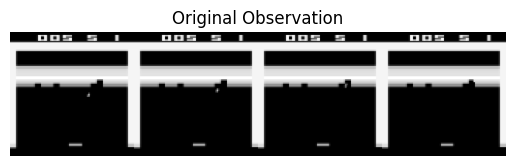

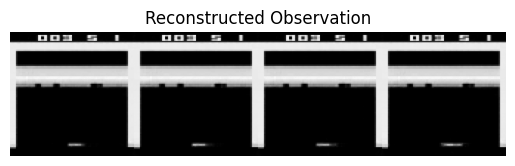

In [ ]:
image = obs_test[0].unsqueeze(0)
reconstructed_image = autoencoder(image)
display_obs(image, 'Original Observation')
display_obs(reconstructed_image, 'Reconstructed Observation')

### above just trained a vanilla autoencoder
image -> latent space -> image

we want

image -> q_net activations -> image, which might be difficult to learn?
but we already have the encoder part, so only train decoder...

In [ ]:
'''
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(512, 64 * 7 * 7),
            nn.ReLU(),
            nn.Linear(64 * 7 * 7, 4 * 84 * 84),
            nn.ReLU(),
        )
    
    def forward(self, x):
        x = self.decoder(x)
        x = x.view(-1, 4, 84, 84)
        return x * 255.0
'''

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(512, 64 * 7 * 7), # 512 hardcoded for layer in probe network
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)), # Matching the flattened dimension in the encoder
            nn.ConvTranspose2d(64, 64, 3, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 4, 8, stride=4),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.decoder(x) * 255.0

decoder = Decoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(decoder.parameters(), lr=0.001)

In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        # Shared layers (up to a certain point)
        self.shared_layers = nn.Sequential(
            nn.Linear(512, 64 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 64, 3, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2),
            nn.ReLU(),
        )

        # Image reconstruction branch
        self.image_layers = nn.Sequential(
            nn.ConvTranspose2d(32, 4, 8, stride=4),
            nn.Sigmoid()
        )

        self.scalar_layers = nn.Sequential(
            nn.Linear(12800, 100),  # Adjusted input size
            nn.ReLU(),
            nn.Linear(100, 2)  # Output two scalar values
        )

    def forward(self, x):
        shared_output = self.shared_layers(x)
        
        # Flatten for scalar branch
        flat_output = shared_output.view(shared_output.size(0), -1)

        # Debug: Print the shape of flat_output
        print(f"Shape of flat_output: {flat_output.shape}")

        # Get image and scalar outputs
        img_output = self.image_layers(shared_output)
        scalar_output = self.scalar_layers(flat_output)

        return img_output * 255.0, scalar_output

decoder = Decoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(decoder.parameters(), lr=0.001)

In [ ]:
encoded_features_train = probe_network.forward_features(obs_train)
encoded_features_train = encoded_features_train.detach()

encoded_features_test = probe_network.forward_features(obs_test)
encoded_features_test = encoded_features_test.detach()

num_epochs = 1000
batch_size = 64

num_batches = len(encoded_features_train) // batch_size

for epoch in range(num_epochs):
    for i in range(num_batches):
        # Get the i-th batch of images from obs_train and encoded_features_train
        start_idx = i * batch_size
        end_idx = start_idx + batch_size
        images = obs_train[start_idx:end_idx]
        batch_features = encoded_features_train[start_idx:end_idx]
        
        # Forward pass through decoder
        reconstructed_images, scalars = decoder(batch_features)
        
        # Draw balls on reconstructed images with the predicted scalar values
        # ball has 2x2 size
        for j in range(batch_size):
            x, y = int(scalars[j][0] * 84), int(scalars[j][1] * 84)
            reconstructed_images[j, :, y:y+2, x:x+2] = 255.0

        # Compute the loss
        loss1 = criterion(reconstructed_images, images)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{num_epochs}: Loss: {loss.item()} | ', end='')
        with torch.no_grad():
            test_loss = 0
            for i in range(0, len(encoded_features_test), batch_size):
                batch = encoded_features_test[i:i+batch_size]
                outputs = decoder(batch)
                loss = criterion(outputs, obs_test[i:i+batch_size])
                test_loss += loss.item()
            print(f'Validation Loss: {test_loss / (len(encoded_features_test) // batch_size)}')

Shape of flat_output: torch.Size([64, 12800])


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

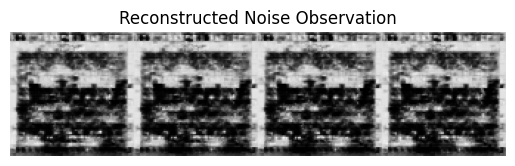

In [ ]:
# reconstruct observations
noise = torch.randn((1, encoded_features_train[0].shape[0])).to(device)
reconstructed_images = decoder(noise)
display_obs(reconstructed_images, 'Reconstructed Noise Observation')

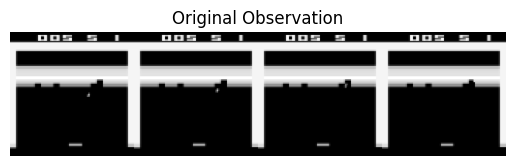

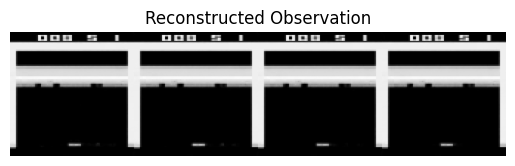

In [ ]:
image = obs_test[0].unsqueeze(0)
encoded = probe_network.forward_features(image)
reconstructed_images = decoder(encoded)
display_obs(image, 'Original Observation')
display_obs(reconstructed_images, 'Reconstructed Observation')

### Concept backprop with decoder

In [ ]:
# same code, but loss2 calculation and perturbation is different
# have to calculate probe values differently

pertubation_lr = 0.01
epochs = 100
loss_factor1 = 1
loss_factor2 = 1

# get shape of encoded features
acts_dummy = probe_network.forward_features(obs_test[0].unsqueeze(0))
perturbation = torch.zeros_like(acts_dummy, requires_grad=True).to(device)

initial_prediction = probe_network.forward_probe(probe_network.forward_features(example_obs) + perturbation)
print(f"Initial Prediction: {initial_prediction}")

for i in range(epochs):
    features = probe_network.forward_features(example_obs) + perturbation
    concept_value_pred = probe_network.forward_probe(features)
    decoded = decoder(features)
    loss1 = loss_factor1 * torch.norm(concept_value_pred - target_concept_value, p=1)
    loss2 = loss_factor2 * torch.norm(decoded - example_obs, p=2)
    total_loss = loss1 + loss2

    if i % 10 == 0:
        print(f"Epoch {i:3d} - Loss1: {loss1:.4f}, Loss2: {loss2:.4f}, Total Loss: {total_loss:.4f}")
    total_loss.backward()

    # update perturbation
    with torch.no_grad():
        perturbation -= pertubation_lr * perturbation.grad
        perturbation.grad.zero_()

final_prediction = probe_network.forward_probe(probe_network.forward_features(example_obs) + perturbation)
print(f"Final Prediction: {final_prediction}")

In [ ]:
probe_network.forward_probe(probe_network.forward_features(example_obs) + perturbation)

In [ ]:
display_obs(example_obs, 'Input Observation')
decoded = decoder(probe_network.forward_features(example_obs) + perturbation)
display_obs(decoded, 'Reconstructed Pertubated Observation')